# Spark SQL and DataFrames:Interacting with External Data Sources

In the previous chapter, we explored interacting with the built-in data sources in
Spark. We also took a closer look at the DataFrame API and its interoperability with
Spark SQL. In this chapter, we will focus on how Spark SQL interfaces with external
components. Specifically, we discuss how Spark SQL allows you to:
* Use user-defined functions for both Apache Hive and Apache Spark.
* Connect with external data sources such as JDBC and SQL databases, PostgreSQL, MySQL, Tableau, Azure Cosmos DB, and MS SQL Server.
* Work with simple and complex types, higher-order functions, and common relational operators.

We’ll also look at some different options for querying Spark using Spark SQL, such as
the Spark SQL shell, Beeline, and Tableau.

## Spark SQL and Apache Hive
Spark SQL is a foundational component of Apache Spark that integrates relational
processing with Spark’s functional programming API. Its genesis was in previous
work on Shark. Shark was originally built on the Hive codebase on top of Apache
Spark and became one of the first interactive SQL query engines on Hadoop systems.
It demonstrated that it was possible to have the best of both worlds; as fast as an
enterprise data warehouse, and scaling as well as Hive/MapReduce.

Spark SQL lets Spark programmers leverage the benefits of faster performance and
relational programming (e.g., declarative queries and optimized storage), as well as
call complex analytics libraries (e.g., machine learning). As discussed in the previous
chapter, as of Apache Spark 2.x, the SparkSession provides a single unified entry
point to manipulate data in Spark.

## User-Defined Functions
While Apache Spark has a plethora of built-in functions, the flexibility of Spark
allows for data engineers and data scientists to define their own functions too. These
are known as user-defined functions (UDFs).

#### Spark SQL UDFs
The benefit of creating your own PySpark or Scala UDFs is that you (and others) will
be able to make use of them within Spark SQL itself. For example, a data scientist can
wrap an ML model within a UDF so that a data analyst can query its predictions in
Spark SQL without necessarily understanding the internals of the model.

Here’s a simplified example of creating a Spark SQL UDF. Note that UDFs operate per
session and they will not be persisted in the underlying metastore:
~~~
// In Scala
// Create cubed function
val cubed = (s: Long) => {
 s * s * s
}
// Register UDF
spark.udf.register("cubed", cubed)
// Create temporary view
spark.range(1, 9).createOrReplaceTempView("udf_test")
# In Python
from pyspark.sql.types import LongType
# Create cubed function
def cubed(s):
 return s * s * s
# Register UDF
spark.udf.register("cubed", cubed, LongType())
# Generate temporary view
spark.range(1, 9).createOrReplaceTempView("udf_test")
~~~
You can now use Spark SQL to execute either of these cubed() functions:
~~~
// In Scala/Python
// Query the cubed UDF
spark.sql("SELECT id, cubed(id) AS id_cubed FROM udf_test").show()
+---+--------+
| id|id_cubed|
+---+--------+
| 1| 1|
| 2| 8|
| 3| 27|
| 4| 64|
| 5| 125|
| 6| 216|
| 7| 343|
| 8| 512|
+---+--------+
~~~
___Evaluation order and null checking in Spark SQL___

Spark SQL (this includes SQL, the DataFrame API, and the Dataset API) does not
guarantee the order of evaluation of subexpressions. For example, the following query
does not guarantee that the s is NOT NULL clause is executed prior to the strlen(s)
\> 1 clause:
~~~
spark.sql("SELECT s FROM test1 WHERE s IS NOT NULL AND strlen(s) > 1")
~~~
Therefore, to perform proper null checking, it is recommended that you do the
following:
1. Make the UDF itself null-aware and do null checking inside the UDF.
2. Use IF or CASE WHEN expressions to do the null check and invoke the UDF in a
conditional branch.

___Speeding up and distributing PySpark UDFs with Pandas UDFs___

One of the previous prevailing issues with using PySpark UDFs was that they had
slower performance than Scala UDFs. This was because the PySpark UDFs required
data movement between the JVM and Python, which was quite expensive. To resolve
this problem, Pandas UDFs (also known as vectorized UDFs) were introduced as part
of Apache Spark 2.3. A Pandas UDF uses Apache Arrow to transfer data and Pandas
to work with the data. You define a Pandas UDF using the keyword pandas_udf as
the decorator, or to wrap the function itself. Once the data is in Apache Arrow format, there is no longer the need to serialize/pickle the data as it is already in a format
consumable by the Python process. Instead of operating on individual inputs row by
row, you are operating on a Pandas Series or DataFrame (i.e., vectorized execution).

From Apache Spark 3.0 with Python 3.6 and above, Pandas UDFs were split into two
API categories: Pandas UDFs and Pandas Function APIs.

___Pandas UDFs___

With Apache Spark 3.0, Pandas UDFs infer the Pandas UDF type from Python
type hints in Pandas UDFs such as pandas.Series, pandas.DataFrame, Tuple,
and Iterator. Previously you needed to manually define and specify each Pandas UDF type. Currently, the supported cases of Python type hints in Pandas
UDFs are Series to Series, Iterator of Series to Iterator of Series, Iterator of Multiple Series to Iterator of Series, and Series to Scalar (a single value).

___Pandas Function APIs___

Pandas Function APIs allow you to directly apply a local Python function to a
PySpark DataFrame where both the input and output are Pandas instances. For
Spark 3.0, the supported Pandas Function APIs are grouped map, map, cogrouped map.

For more information, refer to “Redesigned Pandas UDFs with Python Type Hints”
on page 354 in Chapter 12.
The following is an example of a scalar Pandas UDF for Spark 3.0:2
~~~
# In Python
# Import pandas
import pandas as pd
# Import various pyspark SQL functions including pandas_udf
from pyspark.sql.functions import col, pandas_udf
from pyspark.sql.types import LongType
# Declare the cubed function
def cubed(a: pd.Series) -> pd.Series:
 return a * a * a
# Create the pandas UDF for the cubed function
cubed_udf = pandas_udf(cubed, returnType=LongType())
~~~
The preceding code snippet declares a function called cubed() that performs a cubed
operation. This is a regular Pandas function with the additional cubed_udf = pan
das_udf() call to create our Pandas UDF.

Let’s start with a simple Pandas Series (as defined for x) and then apply the local function cubed() for the cubed calculation:
~~~
# Create a Pandas Series
x = pd.Series([1, 2, 3])
# The function for a pandas_udf executed with local Pandas data
print(cubed(x))
The output is as follows:
0 1
1 8
2 27
dtype: int64
~~~
Now let’s switch to a Spark DataFrame. We can execute this function as a Spark vec‐
torized UDF as follows:
~~~
# Create a Spark DataFrame, 'spark' is an existing SparkSession
df = spark.range(1, 4)
# Execute function as a Spark vectorized UDF
df.select("id", cubed_udf(col("id"))).show()
Here’s the output:
+---+---------+
| id|cubed(id)|
+---+---------+
| 1| 1|
| 2| 8|
| 3| 27|
+---+---------+
~~~
As opposed to a local function, using a vectorized UDF will result in the execution of
Spark jobs; the previous local function is a Pandas function executed only on the
Spark driver. This becomes more apparent when viewing the Spark UI for one of the
stages of this pandas_udf function (Figure 5-1).

For a deeper dive into Pandas UDFs, refer to pandas user-defined functions documentation.
<https://docs.databricks.com/spark/latest/spark-sql/udf-python-pandas.html>

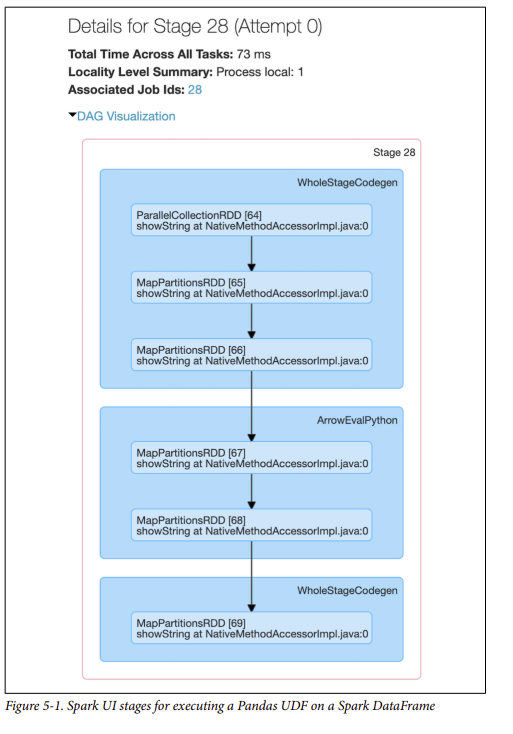
Like many Spark jobs, the job starts with parallelize() to send local data (Arrow
binary batches) to executors and calls mapPartitions() to convert the Arrow binary
batches to Spark’s internal data format, which can be distributed to the Spark workers. There are a number of WholeStageCodegen steps, which represent a fundamental
step up in performance (thanks to Project Tungsten’s whole-stage code generation,
which significantly improves CPU efficiency and performance). But it is the ArrowE
valPython step that identifies that (in this case) a Pandas UDF is being executed.

## Querying with the Spark SQL Shell, Beeline, and Tableau
There are various mechanisms to query Apache Spark, including the Spark SQL shell,
the Beeline CLI utility, and reporting tools like Tableau and Power BI.

In this section, we include instructions for Tableau; for Power BI, please refer to the
documentation.

#### Using the Spark SQL Shell
A convenient tool for executing Spark SQL queries is the spark-sql CLI. While this
utility communicates with the Hive metastore service in local mode, it does not talk
to the Thrift JDBC/ODBC server (a.k.a. Spark Thrift Server or STS). The STS allows
JDBC/ODBC clients to execute SQL queries over JDBC and ODBC protocols on
Apache Spark.

To start the Spark SQL CLI, execute the following command in the $SPARK_HOME
folder:
~~~
./bin/spark-sql
~~~
Once you’ve started the shell, you can use it to interactively perform Spark SQL queries. Let’s take a look at a few examples.

___Create a table___

To create a new permanent Spark SQL table, execute the following statement:
~~~
spark-sql> CREATE TABLE people (name STRING, age int);
~~~
Your output should be similar to this, noting the creation of the Spark SQL table
people as well as its file location (/user/hive/warehouse/people):
~~~
20/01/11 22:42:16 WARN HiveMetaStore: Location: file:/user/hive/warehouse/people
specified for non-external table:people
Time taken: 0.63 seconds
~~~

___Insert data into the table___

You can insert data into a Spark SQL table by executing a statement similar to:
~~~
INSERT INTO people SELECT name, age FROM ...
~~~
As you’re not dependent on loading data from a preexisting table or file, you can
insert data into the table using INSERT...VALUES statements. These three statements
insert three individuals (their names and ages, if known) into the people table:
~~~
spark-sql> INSERT INTO people VALUES ("Michael", NULL);
Time taken: 1.696 seconds
spark-sql> INSERT INTO people VALUES ("Andy", 30);
Time taken: 0.744 seconds
spark-sql> INSERT INTO people VALUES ("Samantha", 19);
Time taken: 0.637 seconds
spark-sql>
~~~

___Running a Spark SQL query___

Now that you have data in your table, you can run Spark SQL queries against it. Let’s
start by viewing what tables exist in our metastore:
~~~
spark-sql> SHOW TABLES;
default people false
Time taken: 0.016 seconds, Fetched 1 row(s)
~~~
Next, let’s find out how many people in our table are younger than 20 years of age:
~~~
spark-sql> SELECT * FROM people WHERE age < 20;
Samantha 19
Time taken: 0.593 seconds, Fetched 1 row(s)
~~~
As well, let’s see who the individuals are who did not specify their age:
~~~
spark-sql> SELECT name FROM people WHERE age IS NULL;
Michael
Time taken: 0.272 seconds, Fetched 1 row(s)
~~~

## Working with Beeline
If you’ve worked with Apache Hive you may be familiar with the command-line tool
Beeline, a common utility for running HiveQL queries against HiveServer2. Beeline
is a JDBC client based on the SQLLine CLI. You can use this same utility to execute
Spark SQL queries against the Spark Thrift server. Note that the currently implemented Thrift JDBC/ODBC server corresponds to HiveServer2 in Hive 1.2.1. You
can test the JDBC server with the following Beeline script that comes with either
Spark or Hive 1.2.1.

___Start the Thrift server___

To start the Spark Thrift JDBC/ODBC server, execute the following command from
the $SPARK_HOME folder:
~~~
./sbin/start-thriftserver.sh
~~~
If you have not already started your Spark driver and worker, execute the following command prior to start-thriftserver.sh:
~~~
./sbin/start-all.sh
~~~

___Connect to the Thrift server via Beeline___

To test the Thrift JDBC/ODBC server using Beeline, execute the following command:
~~~
./bin/beeline
~~~
Then configure Beeline to connect to the local Thrift server:
~~~
!connect jdbc:hive2://localhost:10000
~~~
By default, Beeline is in non-secure mode. Thus, the username is
your login (e.g., user@learningspark.org) and the password is
blank.

___Execute a Spark SQL query with Beeline___

From here, you can run a Spark SQL query similar to how you would run a Hive
query with Beeline. Here are a few sample queries and their output:
~~~
0: jdbc:hive2://localhost:10000> SHOW tables;
+-----------+------------+--------------+
| database | tableName | isTemporary |
+-----------+------------+--------------+
| default | people | false |
+-----------+------------+--------------+
1 row selected (0.417 seconds)
0: jdbc:hive2://localhost:10000> SELECT * FROM people;
+-----------+-------+
| name | age |
+-----------+-------+
| Samantha | 19 |
| Andy | 30 |
| Michael | NULL |
+-----------+-------+
3 rows selected (1.512 seconds)
0: jdbc:hive2://localhost:10000>
~~~

___Stop the Thrift server___

Once you’re done, you can stop the Thrift server with the following command:
~~~
./sbin/stop-thriftserver.sh
~~~

## Working with Tableau
Similar to running queries through Beeline or the Spark SQL CLI, you can connect
your favorite BI tool to Spark SQL via the Thrift JDBC/ODBC server. In this section,
we will show you how to connect Tableau Desktop (version 2019.2) to your local
Apache Spark instance.

You will need to have the Tableau’s Spark ODBC driver version
1.2.0 or above already installed. If you have installed (or upgraded
to) Tableau 2018.1 or greater, this driver should already be
preinstalled.

___Start the Thrift server___

To start the Spark Thrift JDBC/ODBC server, execute the following command from
the $SPARK_HOME folder:
~~~
./sbin/start-thriftserver.sh
~~~
If you have not already started your Spark driver and worker, exe‐
cute the following command prior to start-thriftserver.sh:
~~~
./sbin/start-all.sh
~~~

___Start Tableau___

If you are starting Tableau for the first time, you will be greeted with a Connect dialog
that allows you to connect to a plethora of data sources. By default, the Spark SQL
option will not be included in the “To a Server” menu on the left (see Figure 5-2).
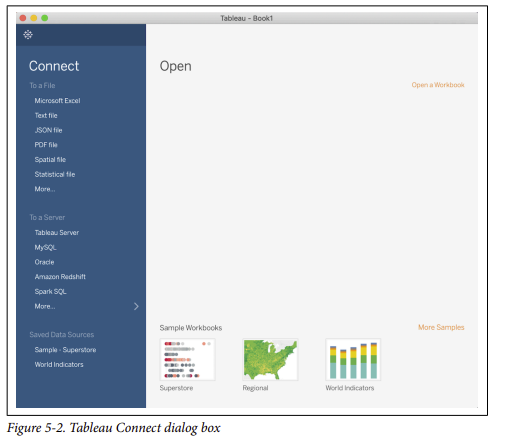
To access the Spark SQL option, click More… at the bottom of that list and then
choose Spark SQL from the list that appears in the main panel, as shown in
Figure 5-3.
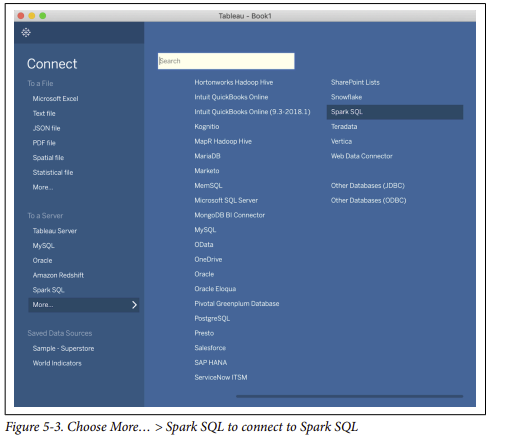
This will pop up the Spark SQL dialog (Figure 5-4). As you’re connecting to a local
Apache Spark instance, you can use the non-secure username authentication mode
with the following parameters:
* Server: localhost
* Port: 10000 (default)
* Type: SparkThriftServer (default)
* Authentication: Username
* Username: Your login, e.g., user@learningspark.org
* Require SSL: Not checked
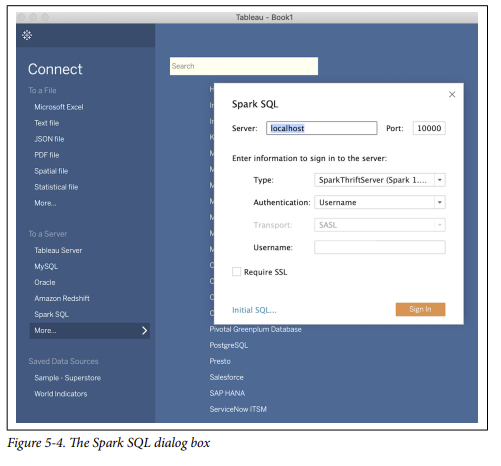
Once you have successfully connected to the Spark SQL data source, you will see a
Data Source Connections view similar to Figure 5-5.
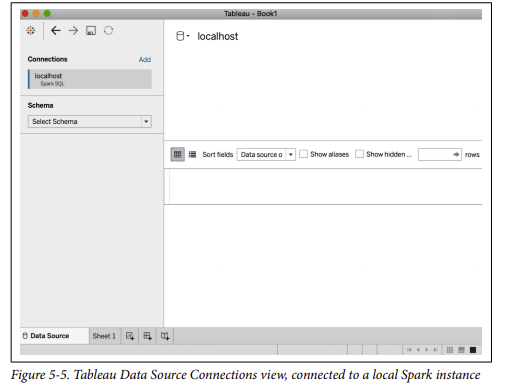
From the Select Schema drop-down menu on the left, choose “default.” Then enter
the name of the table you want to query (see Figure 5-6). Note that you can click the
magnifying glass icon to get a full list of the tables that are available.
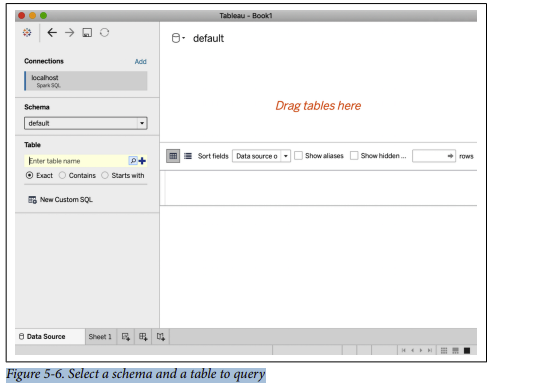
For more information on using Tableau to connect to a Spark SQL
database, refer to Tableau’s Spark SQL documentation <https://help.tableau.com/current/pro/desktop/en-us/examples_sparksql.htm> and the
Databricks Tableau documentation <https://docs.databricks.com/integrations/bi/tableau.html>.

Enter people as the table name, then drag and drop the table from the left side into
the main dialog (in the space marked “Drag tables here”). You should see something
like Figure 5-7.
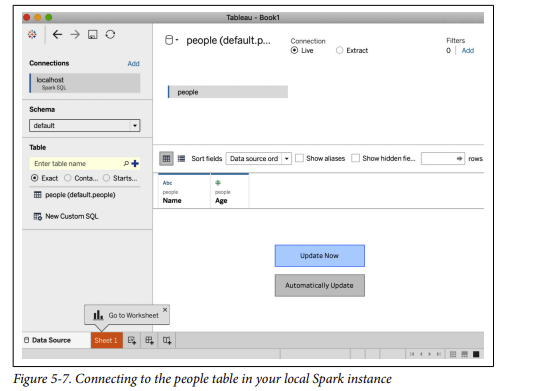
Click Update Now, and under the covers Tableau will query your Spark SQL data
source (Figure 5-8).
You can now execute queries against your Spark data source, join tables, and more,
just like with any other Tableau data source.
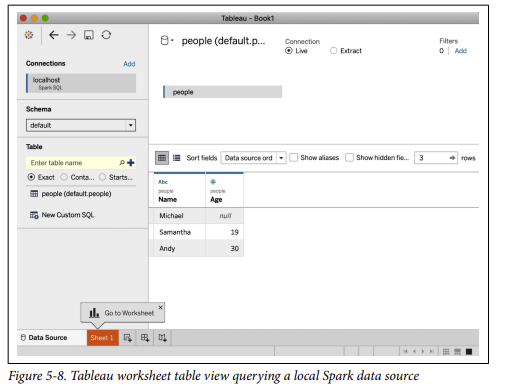

___Stop the Thrift server___
Once you’re done, you can stop the Thrift server with the following command:
~~~
./sbin/stop-thriftserver.sh
~~~

## External Data Sources
In this section, we will focus on how to use Spark SQL to connect to external data
sources, starting with JDBC and SQL databases.

### JDBC and SQL Databases
Spark SQL includes a data source API that can read data from other databases using
JDBC. It simplifies querying these data sources as it returns the results as a DataFrame, thus providing all of the benefits of Spark SQL (including performance and
the ability to join with other data sources).

To get started, you will need to specify the JDBC driver for your JDBC data source
and it will need to be on the Spark classpath. From the \$SPARK_HOME folder, you’ll
issue a command like the following:
~~~
./bin/spark-shell --driver-class-path $database.jar --jars $database.jar
~~~
Using the data source API, the tables from the remote database can be loaded as a
DataFrame or Spark SQL temporary view. Users can specify the JDBC connection
properties in the data source options. Table 5-1 contains some of the more common
connection properties (case-insensitive) that Spark supports.
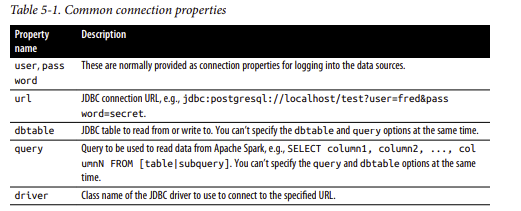
For the full list of connection properties, see the Spark SQL documentation.

___The importance of partitioning___

When transferring large amounts of data between Spark SQL and a JDBC external
source, it is important to partition your data source. All of your data is going through
one driver connection, which can saturate and significantly slow down the performance of your extraction, as well as potentially saturate the resources of your source
system. While these JDBC properties are optional, for any large-scale operations it is
highly recommended to use the properties shown in Table 5-2.
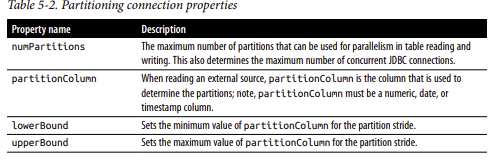

Let’s take a look at an example to help you understand how these properties work.
Suppose we use the following settings:
* numPartitions: 10
* lowerBound: 1000
* upperBound: 10000
Then the stride is equal to 1,000, and 10 partitions will be created. This is the equiva‐
lent of executing these 10 queries (one for each partition):
~~~
• SELECT * FROM table WHERE partitionColumn BETWEEN 1000 and 2000
• SELECT * FROM table WHERE partitionColumn BETWEEN 2000 and 3000
• ...
• SELECT * FROM table WHERE partitionColumn BETWEEN 9000 and 10000
~~~

While not all-encompassing, the following are some hints to keep in mind when
using these properties:
* A good starting point for numPartitions is to use a multiple of the number of
Spark workers. For example, if you have four Spark worker nodes, then perhaps
start with 4 or 8 partitions. But it is also important to note how well your source
system can handle the read requests. For systems that have processing windows,
you can maximize the number of concurrent requests to the source system; for
systems lacking processing windows (e.g., an OLTP system continuously processing data), you should reduce the number of concurrent requests to prevent saturation of the source system.
* Initially, calculate the lowerBound and upperBound based on the minimum and
maximum partitionColumn actual values. For example, if you choose
{numPartitions:10, lowerBound: 1000, upperBound: 10000}, but all of the
values are between 2000 and 4000, then only 2 of the 10 queries (one for each
partition) will be doing all of the work. In this scenario, a better configuration
would be {numPartitions:10, lowerBound: 2000, upperBound: 4000}.
* Choose a partitionColumn that can be uniformly distributed to avoid data skew.
For example, if the majority of your partitionColumn has the value 2500, with
{numPartitions:10, lowerBound: 1000, upperBound: 10000} most of the
work will be performed by the task requesting the values between 2000 and 3000.
Instead, choose a different partitionColumn, or if possible generate a new one
(perhaps a hash of multiple columns) to more evenly distribute your partitions.

### PostgreSQL
To connect to a PostgreSQL database, build or download the JDBC jar from Maven
and add it to your classpath. Then start a Spark shell (spark-shell or pyspark), specifying that jar:
~~~
bin/spark-shell --jars postgresql-42.2.6.jar
~~~
The following examples show how to load from and save to a PostgreSQL database
using the Spark SQL data source API and JDBC in Scala:
~~~
// In Scala
// Read Option 1: Loading data from a JDBC source using load method
val jdbcDF1 = spark
 .read
 .format("jdbc")
 .option("url", "jdbc:postgresql:[DBSERVER]")
 .option("dbtable", "[SCHEMA].[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .load()
// Read Option 2: Loading data from a JDBC source using jdbc method
// Create connection properties
import java.util.Properties
val cxnProp = new Properties()
cxnProp.put("user", "[USERNAME]")
cxnProp.put("password", "[PASSWORD]")
// Load data using the connection properties
val jdbcDF2 = spark
 .read
 .jdbc("jdbc:postgresql:[DBSERVER]", "[SCHEMA].[TABLENAME]", cxnProp)
// Write Option 1: Saving data to a JDBC source using save method
jdbcDF1
 .write
 .format("jdbc")
 .option("url", "jdbc:postgresql:[DBSERVER]")
 .option("dbtable", "[SCHEMA].[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .save()
// Write Option 2: Saving data to a JDBC source using jdbc method
jdbcDF2.write
 .jdbc(s"jdbc:postgresql:[DBSERVER]", "[SCHEMA].[TABLENAME]", cxnProp)
 ~~~
And here’s how to do it in PySpark:
~~~
# In Python
# Read Option 1: Loading data from a JDBC source using load method
jdbcDF1 = (spark
  .read
 .format("jdbc")
 .option("url", "jdbc:postgresql://[DBSERVER]")
 .option("dbtable", "[SCHEMA].[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .load())
# Read Option 2: Loading data from a JDBC source using jdbc method
jdbcDF2 = (spark
 .read
 .jdbc("jdbc:postgresql://[DBSERVER]", "[SCHEMA].[TABLENAME]",
 properties={"user": "[USERNAME]", "password": "[PASSWORD]"}))
# Write Option 1: Saving data to a JDBC source using save method
(jdbcDF1
 .write
 .format("jdbc")
 .option("url", "jdbc:postgresql://[DBSERVER]")
 .option("dbtable", "[SCHEMA].[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .save())
# Write Option 2: Saving data to a JDBC source using jdbc method
(jdbcDF2
 .write
 .jdbc("jdbc:postgresql:[DBSERVER]", "[SCHEMA].[TABLENAME]",
 properties={"user": "[USERNAME]", "password": "[PASSWORD]"}))
~~~

### MySQL
To connect to a MySQL database, build or download the JDBC jar from Maven or
MySQL (the latter is easier!) and add it to your classpath. Then start a Spark shell
(spark-shell or pyspark), specifying that jar:
~~~
bin/spark-shell --jars mysql-connector-java_8.0.16-bin.jar
~~~
The following examples show how to load data from and save it to a MySQL database
using the Spark SQL data source API and JDBC in Scala:
~~~
// In Scala
// Loading data from a JDBC source using load
val jdbcDF = spark
 .read
 .format("jdbc")
 .option("url", "jdbc:mysql://[DBSERVER]:3306/[DATABASE]")
 .option("driver", "com.mysql.jdbc.Driver")
 .option("dbtable", "[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .load()
 // Saving data to a JDBC source using save
jdbcDF
 .write
 .format("jdbc")
 .option("url", "jdbc:mysql://[DBSERVER]:3306/[DATABASE]")
 .option("driver", "com.mysql.jdbc.Driver")
 .option("dbtable", "[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .save()
 ~~~
And here’s how to do it in Python:
~~~
# In Python
# Loading data from a JDBC source using load
jdbcDF = (spark
 .read
 .format("jdbc")
 .option("url", "jdbc:mysql://[DBSERVER]:3306/[DATABASE]")
 .option("driver", "com.mysql.jdbc.Driver")
 .option("dbtable", "[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .load())
# Saving data to a JDBC source using save
(jdbcDF
 .write
 .format("jdbc")
 .option("url", "jdbc:mysql://[DBSERVER]:3306/[DATABASE]")
 .option("driver", "com.mysql.jdbc.Driver")
 .option("dbtable", "[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .save())
~~~

### Azure Cosmos DB
To connect to an Azure Cosmos DB database, build or download the JDBC jar from
Maven or GitHub and add it to your classpath. Then start a Scala or PySpark shell,
specifying this jar (note that this example is using Spark 2.4):
~~~
bin/spark-shell --jars azure-cosmosdb-spark_2.4.0_2.11-1.3.5-uber.jar
~~~
You also have the option of using --packages to pull the connector from Spark Pack‐
ages using its Maven coordinates:
~~~
export PKG="com.microsoft.azure:azure-cosmosdb-spark_2.4.0_2.11:1.3.5"
bin/spark-shell --packages $PKG
~~~

The following examples show how to load data from and save it to an Azure Cosmos
DB database using the Spark SQL data source API and JDBC in Scala and PySpark.
Note that it is common to use the query_custom configuration to make use of the
various indexes within Cosmos DB:
~~~
// In Scala
// Import necessary libraries
import com.microsoft.azure.cosmosdb.spark.schema._
import com.microsoft.azure.cosmosdb.spark._
import com.microsoft.azure.cosmosdb.spark.config.Config
// Loading data from Azure Cosmos DB
// Configure connection to your collection
val query = "SELECT c.colA, c.coln FROM c WHERE c.origin = 'SEA'"
val readConfig = Config(Map(
 "Endpoint" -> "https://[ACCOUNT].documents.azure.com:443/",
 "Masterkey" -> "[MASTER KEY]",
 "Database" -> "[DATABASE]",
 "PreferredRegions" -> "Central US;East US2;",
 "Collection" -> "[COLLECTION]",
 "SamplingRatio" -> "1.0",
 "query_custom" -> query
))
// Connect via azure-cosmosdb-spark to create Spark DataFrame
val df = spark.read.cosmosDB(readConfig)
df.count
// Saving data to Azure Cosmos DB
// Configure connection to the sink collection
val writeConfig = Config(Map(
 "Endpoint" -> "https://[ACCOUNT].documents.azure.com:443/",
 "Masterkey" -> "[MASTER KEY]",
 "Database" -> "[DATABASE]",
 "PreferredRegions" -> "Central US;East US2;",
 "Collection" -> "[COLLECTION]",
 "WritingBatchSize" -> "100"
))
// Upsert the DataFrame to Azure Cosmos DB
import org.apache.spark.sql.SaveMode
df.write.mode(SaveMode.Overwrite).cosmosDB(writeConfig)
# In Python
# Loading data from Azure Cosmos DB
# Read configuration
query = "SELECT c.colA, c.coln FROM c WHERE c.origin = 'SEA'"
readConfig = {
 "Endpoint" : "https://[ACCOUNT].documents.azure.com:443/",
 "Masterkey" : "[MASTER KEY]",
 "Database" : "[DATABASE]",
 "preferredRegions" : "Central US;East US2",
 "Collection" : "[COLLECTION]",
 "SamplingRatio" : "1.0",
 "schema_samplesize" : "1000",
 "query_pagesize" : "2147483647",
 "query_custom" : query
}
# Connect via azure-cosmosdb-spark to create Spark DataFrame
df = (spark
 .read
 .format("com.microsoft.azure.cosmosdb.spark")
 .options(**readConfig)
 .load())
# Count the number of flights
df.count()
# Saving data to Azure Cosmos DB
# Write configuration
writeConfig = {
"Endpoint" : "https://[ACCOUNT].documents.azure.com:443/",
"Masterkey" : "[MASTER KEY]",
"Database" : "[DATABASE]",
"Collection" : "[COLLECTION]",
"Upsert" : "true"
}
# Upsert the DataFrame to Azure Cosmos DB
(df.write
 .format("com.microsoft.azure.cosmosdb.spark")
 .options(**writeConfig)
 .save())
~~~

For more information, please refer to the Azure Cosmos DB documentation. <https://github.com/Azure/azure-cosmosdb-spark> 

### MS SQL Server
To connect to an MS SQL Server database, download the JDBC jar <https://docs.microsoft.com/en-us/sql/connect/jdbc/download-microsoft-jdbc-driver-for-sql-server?view=sql-server-2017> and add it to your
classpath. Then start a Scala or PySpark shell, specifying this jar:
~~~
bin/spark-shell --jars mssql-jdbc-7.2.2.jre8.jar
~~~
The following examples show how to load data from and save it to an MS SQL Server
database using the Spark SQL data source API and JDBC in Scala and PySpark:
~~~
// In Scala
// Loading data from a JDBC source
// Configure jdbcUrl
val jdbcUrl = "jdbc:sqlserver://[DBSERVER]:1433;database=[DATABASE]"
// Create a Properties() object to hold the parameters.
// Note, you can create the JDBC URL without passing in the
// user/password parameters directly.
val cxnProp = new Properties()
cxnProp.put("user", "[USERNAME]")
cxnProp.put("password", "[PASSWORD]")
cxnProp.put("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver")
// Load data using the connection properties
val jdbcDF = spark.read.jdbc(jdbcUrl, "[TABLENAME]", cxnProp)
// Saving data to a JDBC source
jdbcDF.write.jdbc(jdbcUrl, "[TABLENAME]", cxnProp)
# In Python
# Configure jdbcUrl
jdbcUrl = "jdbc:sqlserver://[DBSERVER]:1433;database=[DATABASE]"
# Loading data from a JDBC source
jdbcDF = (spark
 .read
 .format("jdbc")
 .option("url", jdbcUrl)
 .option("dbtable", "[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .load())
# Saving data to a JDBC source
(jdbcDF
 .write
 .format("jdbc")
 .option("url", jdbcUrl)
 .option("dbtable", "[TABLENAME]")
 .option("user", "[USERNAME]")
 .option("password", "[PASSWORD]")
 .save())
 ~~~

### Other External Sources
There are just some of the many external data sources Apache Spark can connect to;
other popular data sources include:
* Apache Cassandra
* Snowflake
* MongoDB

## Higher-Order Functions in DataFrames and Spark SQL
Because complex data types are amalgamations of simple data types, it is tempting to
manipulate them directly. There are two typical solutions for manipulating complex
data types:
* Exploding the nested structure into individual rows, applying some function, and
then re-creating the nested structure
* Building a user-defined function

These approaches have the benefit of allowing you to think of the problem in tabular
format. They typically involve (but are not limited to) using utility functions such as
get_json_object(), from_json(), to_json(), explode(), and selectExpr().

Let’s take a closer look at these two options.

##### Option 1: Explode and Collect
In this nested SQL statement, we first explode(values), which creates a new row
(with the id) for each element (value) within values:
~~~
-- In SQL
SELECT id, collect_list(value + 1) AS values
FROM (SELECT id, EXPLODE(values) AS value
 FROM table) x
GROUP BY id
~~~

While collect_list() returns a list of objects with duplicates, the GROUP BY state‐
ment requires shuffle operations, meaning the order of the re-collected array isn’t
necessarily the same as that of the original array. As values could be any number of
dimensions (a really wide and/or really long array) and we’re doing a GROUP BY, this
approach could be very expensive.
##### Option 2: User-Defined Function
To perform the same task (adding 1 to each element in values), we can also create a
UDF that uses map() to iterate through each element (value) and perform the addition operation:
~~~
-- In SQL
SELECT id, collect_list(value + 1) AS values
FROM (SELECT id, EXPLODE(values) AS value
 FROM table) x
GROUP BY id
~~~

We could then use this UDF in Spark SQL as follows:
~~~
spark.sql("SELECT id, plusOneInt(values) AS values FROM table").show()
~~~

While this is better than using explode() and collect_list() as there won’t be any
ordering issues, the serialization and deserialization process itself may be expensive.
It’s also important to note, however, that collect_list() may cause executors to
experience out-of-memory issues for large data sets, whereas using UDFs would alleviate these issues.

### Built-in Functions for Complex Data Types
Instead of using these potentially expensive techniques, you may be able to use some
of the built-in functions for complex data types included as part of Apache Spark 2.4
and later. Some of the more common ones are listed in Table 5-3 (array types) and
Table 5-4 (map types); for the full list refer to this notebook in the Databricks
documentation.
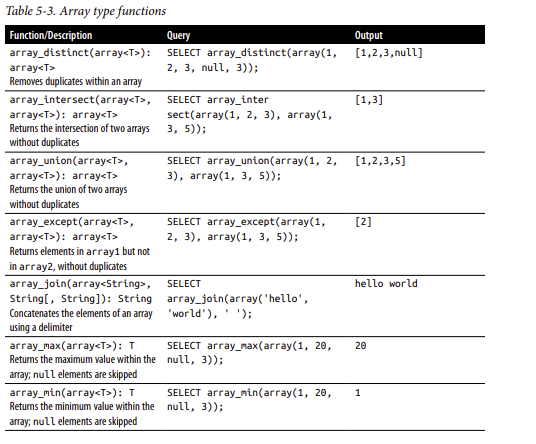
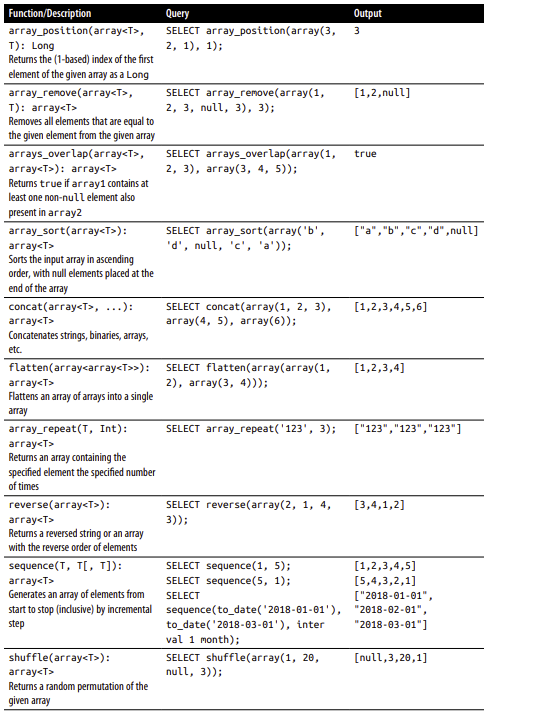
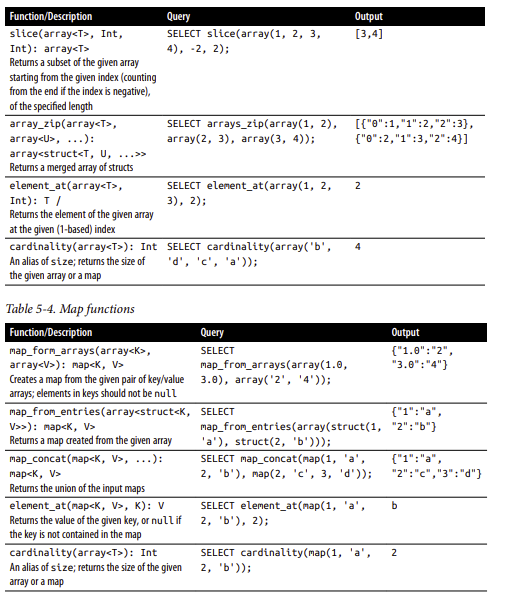

### Higher-Order Functions
In addition to the previously noted built-in functions, there are higher-order functions that take anonymous lambda functions as arguments. An example of a higherorder function is the following:
~~~
-- In SQL
transform(values, value -> lambda expression)
~~~

The transform() function takes an array (values) and anonymous function (lambda
expression) as input. The function transparently creates a new array by applying the
anonymous function to each element, and then assigning the result to the output
array (similar to the UDF approach, but more efficiently).

Let’s create a sample data set so we can run some examples:
~~~
# In Python
from pyspark.sql.types import *
schema = StructType([StructField("celsius", ArrayType(IntegerType()))])
t_list = [[35, 36, 32, 30, 40, 42, 38]], [[31, 32, 34, 55, 56]]
t_c = spark.createDataFrame(t_list, schema)
t_c.createOrReplaceTempView("tC")
# Show the DataFrame
t_c.show()
// In Scala
// Create DataFrame with two rows of two arrays (tempc1, tempc2)
val t1 = Array(35, 36, 32, 30, 40, 42, 38)
val t2 = Array(31, 32, 34, 55, 56)
val tC = Seq(t1, t2).toDF("celsius")
tC.createOrReplaceTempView("tC")
// Show the DataFrame
tC.show()
Here’s the output:
+--------------------+
| celsius|
+--------------------+
|[35, 36, 32, 30, ...|
|[31, 32, 34, 55, 56]|
+--------------------+
~~~
With the preceding DataFrame you can run the following higher-order function
queries.

___transform()___
~~~
transform(array<T>, function<T, U>): array<U>
~~~
The transform() function produces an array by applying a function to each element
of the input array (similar to a map() function):
~~~
// In Scala/Python
// Calculate Fahrenheit from Celsius for an array of temperatures
spark.sql("""
SELECT celsius, 
 transform(celsius, t -> ((t * 9) div 5) + 32) as fahrenheit
 FROM tC
""").show()
+--------------------+--------------------+
| celsius| fahrenheit|
+--------------------+--------------------+
|[35, 36, 32, 30, ...|[95, 96, 89, 86, ...|
|[31, 32, 34, 55, 56]|[87, 89, 93, 131,...|
+--------------------+--------------------+
~~~

___filter()___
~~~
filter(array<T>, function<T, Boolean>): array<T>
~~~
The filter() function produces an array consisting of only the elements of the input
array for which the Boolean function is true:
~~~
// In Scala/Python
// Filter temperatures > 38C for array of temperatures
spark.sql("""
SELECT celsius,
 filter(celsius, t -> t > 38) as high
 FROM tC
""").show()
+--------------------+--------+~~~
| celsius| high|
+--------------------+--------+
|[35, 36, 32, 30, ...|[40, 42]|
|[31, 32, 34, 55, 56]|[55, 56]|
+--------------------+--------+
~~~

___exists()___
~~~
exists(array<T>, function<T, V, Boolean>): Boolean
~~~
The exists() function returns true if the Boolean function holds for any element in
the input array:
~~~
// In Scala/Python
// Is there a temperature of 38C in the ~~~array of temperatures
spark.sql("""
SELECT celsius,
 exists(celsius, t -> t = 38) as threshold
 FROM tC
""").show()
+--------------------+---------+
| celsius|threshold|
+--------------------+---------+
|[35, 36, 32, 30, ...| true|
|[31, 32, 34, 55, 56]| false|
+--------------------+---------+
reduce()
reduce(array<T>, B, function<B, T, B>, function<B, R>)
The reduce() function reduces the elements of the array to a single value by merging
the elements into a buffer B using function<B, T, B> and applying a finishing
function<B, R> on the final buffer:
// In Scala/Python
// Calculate average temperature and convert to F
spark.sql("""
SELECT celsius,
 reduce(
 celsius,
 0,
 (t, acc) -> t + acc,
 acc -> (acc div size(celsius) * 9 div 5) + 32
 ) as avgFahrenheit
 FROM tC
""").show()
+--------------------+-------------+
| celsius|avgFahrenheit|
+--------------------+-------------+
|[35, 36, 32, 30, ...| 96|
|[31, 32, 34, 55, 56]| 105|
+--------------------+-------------+
~~~

## Common DataFrames and Spark SQL Operations
Part of the power of Spark SQL comes from the wide range of DataFrame operations
(also known as untyped Dataset operations) it supports. The list of operations is quite
extensive and includes:
* Aggregate functions
* Collection functions
* Datetime functions
* Math functions
* Miscellaneous functions
* Non-aggregate functions
* Sorting functions
* String functions
* UDF functions
* Window functions

For the full list, see the Spark SQL documentation.
Within this chapter, we will focus on the following common relational operations:
* Unions and joins
* Windowing
* Modifications

To perform these DataFrame operations, we’ll first prepare some data. In the following code snippet, we:
1. Import two files and create two DataFrames, one for airport (airportsna) information and one for US flight delays (departureDelays).
2. Using expr(), convert the delay and distance columns from STRING to INT.
3. Create a smaller table, foo, that we can focus on for our demo examples; it contains only information on three flights originating from Seattle (SEA) to the destination of San Francisco (SFO) for a small time range.

Let’s get started:
~~~
// In Scala
import org.apache.spark.sql.functions._
// Set file paths
val delaysPath =
 "/databricks-datasets/learning-spark-v2/flights/departuredelays.csv"
val airportsPath =
 "/databricks-datasets/learning-spark-v2/flights/airport-codes-na.txt"
// Obtain airports data set
val airports = spark.read
 .option("header", "true")
 .option("inferschema", "true")
 .option("delimiter", "\t")
 .csv(airportsPath)
airports.createOrReplaceTempView("airports_na")
// Obtain departure Delays data set
val delays = spark.read
 .option("header","true")
 .csv(delaysPath)
 .withColumn("delay", expr("CAST(delay as INT) as delay"))
 .withColumn("distance", expr("CAST(distance as INT) as distance"))
delays.createOrReplaceTempView("departureDelays")
// Create temporary small table
val foo = delays.filter(
 expr("""origin == 'SEA' AND destination == 'SFO' AND
 date like '01010%' AND delay > 0"""))
foo.createOrReplaceTempView("foo")
# In Python
# Set file paths
from pyspark.sql.functions import expr
tripdelaysFilePath =
 "/databricks-datasets/learning-spark-v2/flights/departuredelays.csv"
airportsnaFilePath =
 "/databricks-datasets/learning-spark-v2/flights/airport-codes-na.txt"

# Obtain airports data set
airportsna = (spark.read
 .format("csv")
 .options(header="true", inferSchema="true", sep="\t")
 .load(airportsnaFilePath))
airportsna.createOrReplaceTempView("airports_na")
# Obtain departure delays data set
departureDelays = (spark.read
 .format("csv")
 .options(header="true")
 .load(tripdelaysFilePath))
departureDelays = (departureDelays
 .withColumn("delay", expr("CAST(delay as INT) as delay"))
 .withColumn("distance", expr("CAST(distance as INT) as distance")))
departureDelays.createOrReplaceTempView("departureDelays")
# Create temporary small table
foo = (departureDelays
 .filter(expr("""origin == 'SEA' and destination == 'SFO' and
 date like '01010%' and delay > 0""")))
foo.createOrReplaceTempView("foo")
~~~

The departureDelays DataFrame contains data on >1.3M flights while the foo Data‐
Frame contains just three rows with information on flights from SEA to SFO for a
specific time range, as noted in the following output:
~~~
// Scala/Python
spark.sql("SELECT * FROM airports_na LIMIT 10").show()
+-----------+-----+-------+----+
| City|State|Country|IATA|
+-----------+-----+-------+----+
| Abbotsford| BC| Canada| YXX|
| Aberdeen| SD| USA| ABR|
| Abilene| TX| USA| ABI|
| Akron| OH| USA| CAK|
| Alamosa| CO| USA| ALS|
| Albany| GA| USA| ABY|
| Albany| NY| USA| ALB|
|Albuquerque| NM| USA| ABQ|
| Alexandria| LA| USA| AEX|
| Allentown| PA| USA| ABE|
+-----------+-----+-------+----+
spark.sql("SELECT * FROM departureDelays LIMIT 10").show()
+--------+-----+--------+------+-----------+
| date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245| 6| 602| ABE| ATL|
|01020600| -8| 369| ABE| DTW|
|01021245| -2| 602| ABE| ATL|
|01020605| -4| 602| ABE| ATL|
|01031245| -4| 602| ABE| ATL|
|01030605| 0| 602| ABE| ATL|
|01041243| 10| 602| ABE| ATL|
|01040605| 28| 602| ABE| ATL|
|01051245| 88| 602| ABE| ATL|
|01050605| 9| 602| ABE| ATL|
+--------+-----+--------+------+-----------+
spark.sql("SELECT * FROM foo").show()
+--------+-----+--------+------+-----------+
| date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01010710| 31| 590| SEA| SFO|
|01010955| 104| 590| SEA| SFO|
|01010730| 5| 590| SEA| SFO|
+--------+-----+--------+------+-----------+
~~~

In the following sections, we will execute union, join, and windowing examples with
this data.

#### Unions
A common pattern within Apache Spark is to union two different DataFrames with
the same schema together. This can be achieved using the union() method:
~~~
// Scala
// Union two tables
val bar = delays.union(foo)
bar.createOrReplaceTempView("bar")
bar.filter(expr("""origin == 'SEA' AND destination == 'SFO'
AND date LIKE '01010%' AND delay > 0""")).show()
# In Python
# Union two tables
bar = departureDelays.union(foo)
bar.createOrReplaceTempView("bar")
# Show the union (filtering for SEA and SFO in a specific time range)
bar.filter(expr("""origin == 'SEA' AND destination == 'SFO'
AND date LIKE '01010%' AND delay > 0""")).show()
~~~

The bar DataFrame is the union of foo with delays. Using the same filtering criteria
results in the bar DataFrame, we see a duplication of the foo data, as expected:
~~~
-- In SQL
spark.sql("""
SELECT *
 FROM bar
 WHERE origin = 'SEA'
 AND destination = 'SFO'
 AND date LIKE '01010%'
 AND delay > 0
""").show()
+--------+-----+--------+------+-----------+
| date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01010710| 31| 590| SEA| SFO|
|01010955| 104| 590| SEA| SFO|
|01010730| 5| 590| SEA| SFO|
|01010710| 31| 590| SEA| SFO|
|01010955| 104| 590| SEA| SFO|
|01010730| 5| 590| SEA| SFO|
+--------+-----+--------+------+-----------+
~~~

#### Joins
A common DataFrame operation is to join two DataFrames (or tables) together. By
default, a Spark SQL join is an inner join, with the options being inner, cross,
outer, full, full_outer, left, left_outer, right, right_outer, left_semi, and
left_anti. More information is available in the documentation (this is applicable to
Scala as well as Python).

The following code sample performs the default of an inner join between the air
portsna and foo DataFrames:
~~~
// In Scala
foo.join(
 airports.as('air),
 $"air.IATA" === $"origin"
).select("City", "State", "date", "delay", "distance", "destination").show()
# In Python
# Join departure delays data (foo) with airport info
foo.join(
 airports,
 airports.IATA == foo.origin
).select("City", "State", "date", "delay", "distance", "destination").show()
-- In SQL
spark.sql("""
SELECT a.City, a.State, f.date, f.delay, f.distance, f.destination
 FROM foo f
 JOIN airports_na a
 ON a.IATA = f.origin
""").show()
~~~

The preceding code allows you to view the date, delay, distance, and destination
information from the foo DataFrame joined to the city and state information from
the airports DataFrame:
~~~
+-------+-----+--------+-----+--------+-----------+
| City|State| date|delay|distance|destination|
+-------+-----+--------+-----+--------+-----------+
|Seattle| WA|01010710| 31| 590| SFO|
|Seattle| WA|01010955| 104| 590| SFO|
|Seattle| WA|01010730| 5| 590| SFO|
+-------+-----+--------+-----+--------+-----------+
~~~

#### Windowing
A window function uses values from the rows in a window (a range of input rows) to
return a set of values, typically in the form of another row. With window functions, it
is possible to operate on a group of rows while still returning a single value for every
input row. In this section, we will show how to use the dense_rank() window func‐
tion; there are many other functions, as noted in Table 5-5.
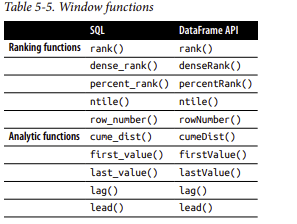
Let’s start with a review of the TotalDelays (calculated by sum(Delay)) experienced
by flights originating from Seattle (SEA), San Francisco (SFO), and New York City
(JFK) and going to a specific set of destination locations, as noted in the following
query:
~~~
-- In SQL
DROP TABLE IF EXISTS departureDelaysWindow;
CREATE TABLE departureDelaysWindow AS
SELECT origin, destination, SUM(delay) AS TotalDelays
 FROM departureDelays
WHERE origin IN ('SEA', 'SFO', 'JFK')
 AND destination IN ('SEA', 'SFO', 'JFK', 'DEN', 'ORD', 'LAX', 'ATL')
GROUP BY origin, destination;
SELECT * FROM departureDelaysWindow
+------+-----------+-----------+
|origin|destination|TotalDelays|
+------+-----------+-----------+
| JFK| ORD| 5608|
| SEA| LAX| 9359|
| JFK| SFO| 35619|
| SFO| ORD| 27412|
| JFK| DEN| 4315|
| SFO| DEN| 18688|
| SFO| SEA| 17080|
| SEA| SFO| 22293|
| JFK| ATL| 12141|
| SFO| ATL| 5091|
| SEA| DEN| 13645|
| SEA| ATL| 4535|
| SEA| ORD| 10041|
| JFK| SEA| 7856|
| JFK| LAX| 35755|
| SFO| JFK| 24100|
| SFO| LAX| 40798|
| SEA| JFK| 4667|
+------+-----------+-----------+
~~~

What if for each of these origin airports you wanted to find the three destinations that
experienced the most delays? You could achieve this by running three different queries for each origin and then unioning the results together, like this:
~~~
-- In SQL
SELECT origin, destination, SUM(TotalDelays) AS TotalDelays
FROM departureDelaysWindow
WHERE origin = '[ORIGIN]'
GROUP BY origin, destination
ORDER BY SUM(TotalDelays) DESC
LIMIT 3
~~~

where [ORIGIN] is the three different origin values of JFK, SEA, and SFO.
But a better approach would be to use a window function like dense_rank() to per‐
form the following calculation:
~~~
-- In SQL
spark.sql("""
SELECT origin, destination, TotalDelays, rank
 FROM (
 SELECT origin, destination, TotalDelays, dense_rank()
 OVER (PARTITION BY origin ORDER BY TotalDelays DESC) as rank
 FROM departureDelaysWindow
 ) t
 WHERE rank <= 3
""").show()
+------+-----------+-----------+----+
|origin|destination|TotalDelays|rank|
+------+-----------+-----------+----+
| SEA| SFO| 22293| 1|
| SEA| DEN| 13645| 2|
| SEA| ORD| 10041| 3|
| SFO| LAX| 40798| 1|
| SFO| ORD| 27412| 2|
| SFO| JFK| 24100| 3|
| JFK| LAX| 35755| 1|
| JFK| SFO| 35619| 2|
| JFK| ATL| 12141| 3|
+------+-----------+-----------+----+
~~~

By using the dense_rank() window function, we can quickly ascertain that the desti‐
nations with the worst delays for the three origin cities were:
* Seattle (SEA): San Francisco (SFO), Denver (DEN), and Chicago (ORD)
* San Francisco (SFO): Los Angeles (LAX), Chicago (ORD), and New York (JFK)
* New York (JFK): Los Angeles (LAX), San Francisco (SFO), and Atlanta (ATL)

It’s important to note that each window grouping needs to fit in a single executor and
will get composed into a single partition during execution. Therefore, you need to
ensure that your queries are not unbounded (i.e., limit the size of your window).

#### Modifications
Another common operation is to perform modifications to the DataFrame. While
DataFrames themselves are immutable, you can modify them through operations that
create new, different DataFrames, with different columns, for example. (Recall from
earlier chapters that the underlying RDDs are immutable—i.e., they cannot be changed—to ensure there is data lineage for Spark operations.) Let’s start with our
previous small DataFrame example:
~~~
// In Scala/Python
foo.show()
--------+-----+--------+------+-----------+
| date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01010710| 31| 590| SEA| SFO|
|01010955| 104| 590| SEA| SFO|
|01010730| 5| 590| SEA| SFO|
+--------+-----+--------+------+-----------+
~~~

___Adding new columns___

To add a new column to the foo DataFrame, use the withColumn() method:
~~~
// In Scala
import org.apache.spark.sql.functions.expr
val foo2 = foo.withColumn(
 "status",
 expr("CASE WHEN delay <= 10 THEN 'On-time' ELSE 'Delayed' END")
 )
# In Python
from pyspark.sql.functions import expr
foo2 = (foo.withColumn(
 "status",
 expr("CASE WHEN delay <= 10 THEN 'On-time' ELSE 'Delayed' END")
 ))
~~~

The newly created foo2 DataFrame has the contents of the original foo DataFrame
plus the additional status column defined by the CASE statement:
~~~
// In Scala/Python
foo2.show()
+--------+-----+--------+------+-----------+-------+
| date|delay|distance|origin|destination| status|
+--------+-----+--------+------+-----------+-------+
|01010710| 31| 590| SEA| SFO|Delayed|
|01010955| 104| 590| SEA| SFO|Delayed|
|01010730| 5| 590| SEA| SFO|On-time|
+--------+-----+--------+------+-----------+-------+
~~~

___Dropping columns___

To drop a column, use the drop() method. For example, let’s remove the delay col‐
umn as we now have a status column, added in the previous section:
~~~
// In Scala
val foo3 = foo2.drop("delay")
foo3.show()
# In Python
foo3 = foo2.drop("delay")
foo3.show()
+--------+--------+------+-----------+-------+
| date|distance|origin|destination| status|
+--------+--------+------+-----------+-------+
|01010710| 590| SEA| SFO|Delayed|
|01010955| 590| SEA| SFO|Delayed|
|01010730| 590| SEA| SFO|On-time|
+--------+--------+------+-----------+-------+
~~~

___Renaming columns___

You can rename a column using the rename() method:
~~~
// In Scala
val foo4 = foo3.withColumnRenamed("status", "flight_status")
foo4.show()
# In Python
foo4 = foo3.withColumnRenamed("status", "flight_status")
foo4.show()
+--------+--------+------+-----------+-------------+
| date|distance|origin|destination|flight_status|
+--------+--------+------+-----------+-------------+
|01010710| 590| SEA| SFO| Delayed|
|01010955| 590| SEA| SFO| Delayed|
|01010730| 590| SEA| SFO| On-time|
+--------+--------+------+-----------+-------------+
~~~

___Pivoting
When working with your data, sometimes you will need to swap the columns for the
rows—i.e., pivot your data. Let’s grab some data to demonstrate this concept:
~~~
-- In SQL
SELECT destination, CAST(SUBSTRING(date, 0, 2) AS int) AS month, delay
 FROM departureDelays
WHERE origin = 'SEA'
+-----------+-----+-----+
|destination|month|delay|
+-----------+-----+-----+
| ORD| 1| 92|
| JFK| 1| -7|
| DFW| 1| -5|
| MIA| 1| -3|
| DFW| 1| -3|
| DFW| 1| 1|
| ORD| 1| -10|
| DFW| 1| -6|
| DFW| 1| -2|
| ORD| 1| -3|
+-----------+-----+-----+
only showing top 10 rows
~~~

Pivoting allows you to place names in the month column (instead of 1 and 2 you can
show Jan and Feb, respectively) as well as perform aggregate calculations (in this case
average and max) on the delays by destination and month:
~~~
-- In SQL
SELECT * FROM (
SELECT destination, CAST(SUBSTRING(date, 0, 2) AS int) AS month, delay
 FROM departureDelays WHERE origin = 'SEA'
)
PIVOT (
 CAST(AVG(delay) AS DECIMAL(4, 2)) AS AvgDelay, MAX(delay) AS MaxDelay
 FOR month IN (1 JAN, 2 FEB)
)
ORDER BY destination
+-----------+------------+------------+------------+------------+
|destination|JAN_AvgDelay|JAN_MaxDelay|FEB_AvgDelay|FEB_MaxDelay|
+-----------+------------+------------+------------+------------+
| ABQ| 19.86| 316| 11.42| 69|
| ANC| 4.44| 149| 7.90| 141|
| ATL| 11.98| 397| 7.73| 145|
| AUS| 3.48| 50| -0.21| 18|
| BOS| 7.84| 110| 14.58| 152|
| BUR| -2.03| 56| -1.89| 78|
| CLE| 16.00| 27| null| null|
| CLT| 2.53| 41| 12.96| 228|
| COS| 5.32| 82| 12.18| 203|
| CVG| -0.50| 4| null| null|
| DCA| -1.15| 50| 0.07| 34|
| DEN| 13.13| 425| 12.95| 625|
| DFW| 7.95| 247| 12.57| 356|
| DTW| 9.18| 107| 3.47| 77|
| EWR| 9.63| 236| 5.20| 212|
| FAI| 1.84| 160| 4.21| 60|
| FAT| 1.36| 119| 5.22| 232|
| FLL| 2.94| 54| 3.50| 40|
| GEG| 2.28| 63| 2.87| 60|
| HDN| -0.44| 27| -6.50| 0|
+-----------+------------+------------+------------+------------+
only showing top 20 rows
~~~

## Summary
This chapter explored how Spark SQL interfaces with external components. We dis‐
cussed creating user-defined functions, including Pandas UDFs, and presented some
options for executing Spark SQL queries (including the Spark SQL shell, Beeline, and
Tableau). We then provided examples of how to use Spark SQL to connect with a
variety of external data sources, such as SQL databases, PostgreSQL, MySQL, Tableau,
Azure Cosmos DB, MS SQL Server, and others.
We explored Spark’s built-in functions for complex data types, and gave some exam‐
ples of working with higher-order functions. Finally, we discussed some common
relational operators and showed how to perform a selection of DataFrame operations.
In the next chapter, we explore how to work with Datasets, the benefits of strongly
typed operations, and when and why to use them.